# Problème 2 ; EMV avec erreurs de student-$t$

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import chi2

### Préparation des données

In [7]:
import pandas_datareader.data as web

start_date = '1980-01-01'
end_date = '2021-12-31'

ff_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date, end=end_date)[0]

mom_factor = web.DataReader('F-F_Momentum_Factor', 'famafrench', start=start_date, end=end_date)[0]

industries = web.DataReader('17_Industry_Portfolios', 'famafrench', start=start_date, end=end_date)[0]

C:\Users\Xavie\AppData\Local\Temp\ipykernel_33924\2551898418.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date, end=end_date)[0]
C:\Users\Xavie\AppData\Local\Temp\ipykernel_33924\2551898418.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date, end=end_date)[0]
C:\Users\Xavie\AppData\Local\Temp\ipykernel_33924\2551898418.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and

In [8]:
#print(ff_factors)
#print(mom_factor)
#print(industries)

factors = pd.merge(ff_factors, mom_factor, left_index=True, right_index=True)

#Donnée de pourcentage a décimal
factors = factors / 100
industries = industries / 100

#Rendement exédentaire
rf = factors['RF']
excess_industries = industries.sub(rf, axis=0)

factors_final = factors.drop(columns=['RF'])

#Vérification d'alignement des dates
excess_industries = excess_industries.loc['1980':'2021']
factors_final = factors_final.loc['1980':'2021']

#print(excess_industries)
#print(factors_final)

df_final_Food  = excess_industries["Food"]
df_final_Oil   = excess_industries["Oil"]
df_final_Steel = excess_industries["Steel"]

final_data_food = pd.concat([df_final_Food, factors_final], axis=1)

final_data_oil = pd.concat([df_final_Oil, factors_final], axis=1)

final_data_steel = pd.concat([df_final_Steel, factors_final], axis=1)


print(final_data_steel)
print(final_data_food)
print(final_data_food)

          Steel  Mkt-RF     SMB     HML     RMW     CMA     Mom
Date                                                           
1980-01  0.1678  0.0550  0.0188  0.0185 -0.0184  0.0189  0.0745
1980-02 -0.0060 -0.0123 -0.0162  0.0059 -0.0095  0.0292  0.0789
1980-03 -0.1970 -0.1289 -0.0697 -0.0096  0.0182 -0.0105 -0.0958
1980-04  0.0104  0.0396  0.0105  0.0103 -0.0218  0.0034 -0.0048
1980-05  0.0439  0.0526  0.0200  0.0038  0.0043 -0.0063 -0.0118
...         ...     ...     ...     ...     ...     ...     ...
2021-08  0.0351  0.0295 -0.0066 -0.0023 -0.0026 -0.0172  0.0263
2021-09 -0.1064 -0.0440  0.0112  0.0512 -0.0192  0.0200  0.0139
2021-10  0.1014  0.0663 -0.0270 -0.0053  0.0171 -0.0154  0.0332
2021-11 -0.0628 -0.0158 -0.0170 -0.0037  0.0719  0.0170  0.0096
2021-12  0.0978  0.0324 -0.0078  0.0326  0.0488  0.0429 -0.0239

[504 rows x 7 columns]
           Food  Mkt-RF     SMB     HML     RMW     CMA     Mom
Date                                                           
1980-01  0.0306 

### (a) log-vraisemmblance (erreur student-t)

In [9]:
# Fonction qui Calcule la log-vraisemmblance (erreur student-t)
def student_t_likelihood(df, dof):
    
    #Y (variable dépendante)
    y = df.iloc[:, 0]
    #X (régresseurs)
    X = df.iloc[:, 1:]

    X = sm.add_constant(X)
    model = sm.OLS(y,X).fit()

    #écart-type des résidus
    residuals = model.resid
    sigma = residuals.std()
    n = len(residuals)      #nmb d'obs

    #log vraisemblance (LL)

    #C.Gamma
    term1 = gammaln((dof + 1) / 2) - gammaln(dof / 2)

    #Norm. avec pi et sigma
    term2 = -0.5 * np.log(np.pi * dof) - np.log(sigma)

    #noyeau de dist.
    standardized_squared_resid = (residuals**2) / (sigma**2 * dof)
    term3 = -((dof + 1) / 2) * np.log(1 + standardized_squared_resid)

    #LL par obs.
    ll_i = term1 + term2 + term3

    #LL totale
    total_log_likelihood = np.sum(ll_i)

    return total_log_likelihood


#test (food)
ll_val_food = student_t_likelihood(final_data_food, dof=5)
print(f"Log-Vraisemblance (dof=5 (food)): {ll_val_food}")

#test (oil)
ll_val_oil = student_t_likelihood(final_data_oil, dof=5)
print(f"Log-Vraisemblance (dof=5 (oil)): {ll_val_oil}")

#test (steel)
ll_val_steel = student_t_likelihood(final_data_steel, dof=5)
print(f"Log-Vraisemblance (dof=5 (steel)): {ll_val_steel}")



Log-Vraisemblance (dof=5 (food)): 1115.7517924960184
Log-Vraisemblance (dof=5 (oil)): 826.149722533245
Log-Vraisemblance (dof=5 (steel)): 812.6830950669232


### (b) comparaison

In [10]:


def lr_test_student(df, dof):
    ll_unrestricted = student_t_likelihood(df, dof)
    
    #colonne Y seulement
    df_restricted = df.iloc[:, [0]]
    ll_restricted = student_t_likelihood(df_restricted, dof)


    #Statistique LR
    lr_stat = 2 * (ll_unrestricted - ll_restricted)

    #P_value
    n_restrictions = df.shape[1] - 1
    p_value = chi2.sf(lr_stat, df=n_restrictions)

    return lr_stat, p_value


# Choisissez un degré de liberté (ex: 5 pour tester) ou le dof optimal trouvé en (c)
#test (food)
stat, pval = lr_test_student(final_data_food, dof=5)
print(f"-------food-------")
print(f"Statistique LR: {stat:.4f}")
print(f"P-value: {pval:.4e}")

#test (oil)
stat, pval = lr_test_student(final_data_oil, dof=5)
print(f"-------oil--------")
print(f"Statistique LR: {stat:.4f}")
print(f"P-value: {pval:.4e}")

#test (steel)
stat, pval = lr_test_student(final_data_steel, dof=5)
print(f"-------steel-------")
print(f"Statistique LR: {stat:.4f}")
print(f"P-value: {pval:.4e}")

-------food-------
Statistique LR: 458.3011
P-value: 8.0202e-96
-------oil--------
Statistique LR: 293.3855
P-value: 2.1372e-60
-------steel-------
Statistique LR: 536.0451
P-value: 1.4383e-112


### (c) tracage du profil de vraisemblance

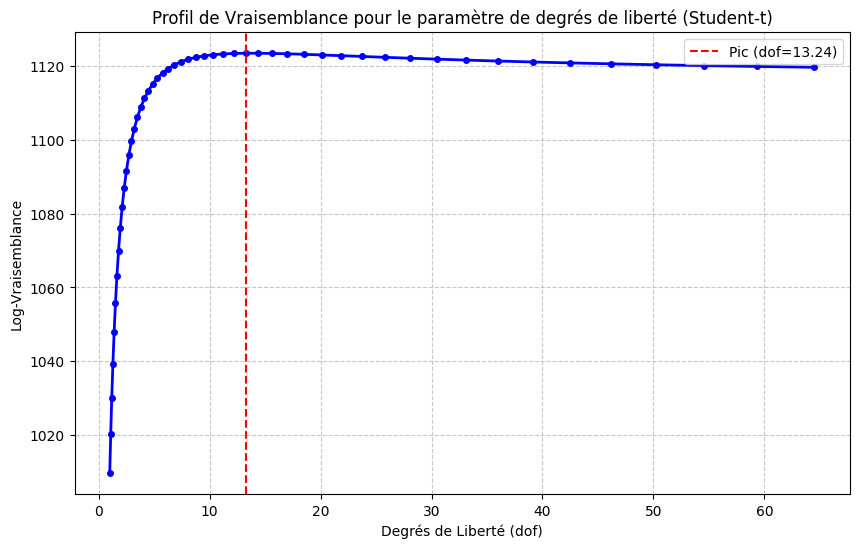

Log-Vraisemblance Maximale atteinte à : 1123.5477
Degrés de liberté optimaux (MLE) : 13.2412


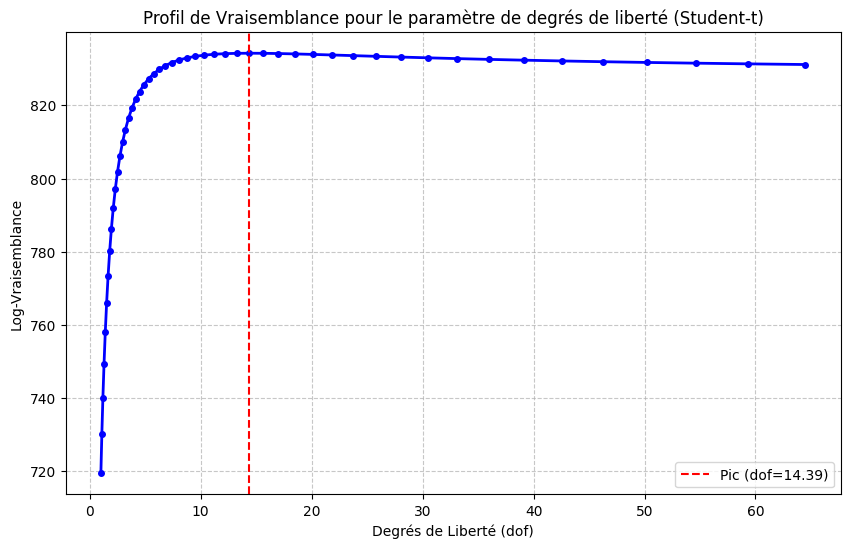

Log-Vraisemblance Maximale atteinte à : 834.2345
Degrés de liberté optimaux (MLE) : 14.3919


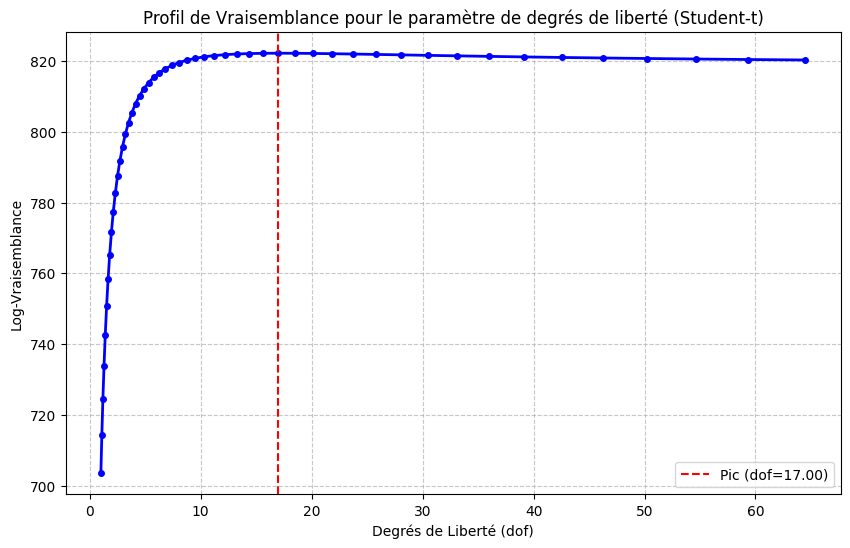

Log-Vraisemblance Maximale atteinte à : 822.1473
Degrés de liberté optimaux (MLE) : 17.0020


In [11]:
def plot_profile_likelihood(df):

    
    #valeurs pour dof (j = 0 à 50)
    j_values = np.arange(51)  # Crée un tableau de 0 à 50
    dof_values = np.exp(j_values / 12)
    
    #Log-Vraisemblance par dof
    ll_values = []
    
    for dof in dof_values:

        ll = student_t_likelihood(df, dof)
        ll_values.append(ll)
        
    #Tracage
    plt.figure(figsize=(10, 6))
    plt.plot(dof_values, ll_values, color='blue', linewidth=2, marker='o', markersize=4)
    
    plt.title('Profil de Vraisemblance pour le paramètre de degrés de liberté (Student-t)')
    plt.xlabel('Degrés de Liberté (dof)')
    plt.ylabel('Log-Vraisemblance')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    #Maximum sur le graphe
    max_ll = np.max(ll_values)
    best_dof = dof_values[np.argmax(ll_values)]
    
    plt.axvline(x=best_dof, color='red', linestyle='--', label=f'Pic (dof={best_dof:.2f})')
    plt.legend()
    
    plt.show()
    
    # Affichage console pour l'analyse
    print(f"Log-Vraisemblance Maximale atteinte à : {max_ll:.4f}")
    print(f"Degrés de liberté optimaux (MLE) : {best_dof:.4f}")


#graphique(food)
plot_profile_likelihood(final_data_food)

#graphique(oil)
plot_profile_likelihood(final_data_oil)

#graphique(steel)
plot_profile_likelihood(final_data_steel)